In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import dirichlet
from scipy.stats import gamma
from scipy.stats import multinomial
from scipy.special import psi
import pandas as pd
from scipy.stats import multinomial
from scipy.stats import nbinom
import time

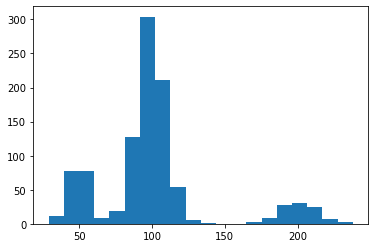

array([722, 175, 103])

In [2]:
true_ratio = [.7,.2,.1]
true_lambda = [100,50,200]
count=np.random.multinomial(1000,true_ratio)
x1 = np.random.poisson(true_lambda[0], count[0])
x2 = np.random.poisson(true_lambda[1], count[1])
x3 = np.random.poisson(true_lambda[2], count[2])
x=(np.concatenate([x1,x2,x3])).reshape(-1,1)
plt.hist(x,bins=20)
plt.show()
count

In [3]:
x1.mean(),x2.mean(),x3.mean()

(99.54570637119113, 49.308571428571426, 201.40776699029126)

In this data, the observations are drwan from 3 poisson distributions with different lambdas.<br />
70% comes from poi(100), 20% comes from poi(50), 10% comes from poi(200)

There are 1,000 obserbations in total. <br />
714 obsevations came from poi(100) and thier sample mean is 100.49.<br />
186 obsevations came from poi(50) and their sample mean is 49.52. <br />
100 obsevations came from poi(200) and thier sample mean is 199.84.  <br />

In [4]:
def log_sum_exponential(tmp):
    denominator = np.log(np.sum(np.exp(tmp - tmp.max(axis=1).reshape(-1,1)), axis=1))+ tmp.max(axis=1)
    result = np.exp(tmp-denominator.reshape(-1,1))
    #without rounding, result[n].sum() could exceed 1. For example,result[0]=[1.02736297e-06, 9.99998973e-01, 7.05605970e-16] result[0].sum()=1.0000000000000024
    return np.round(result,6)
def gibbs_sampling(x,K,max_iter=110):
    start = time.time()
    N=x.size
    lmbd = np.ones((1,K))   # inital lambda (parameter of poisson) 
    pi = np.zeros((1,K)) + 1/K #Initial pi = (1/K, 1/K, ......,1/K)
    a=1 # initial scale of gamma  
    b=1 # initial rate of gamma
    alpha = np.ones((1,K))  # initial alpha of dirichlet
    post_lmbd = np.zeros((max_iter,K)) #store postrior lambda
    post_pi = np.zeros((max_iter,K)) #store posterior pi
    for i in range(max_iter):
        s=np.zeros((N,K)) 
        tmp= x*np.log(lmbd) - lmbd + np.log(pi)
        eta = log_sum_exponential(tmp)
        for n in range(N):
            s[n] = multinomial.rvs(n=1, p=eta[n], size=1) 
            a_hat = x.T.dot(s)  + a
            b_hat = np.sum(s, axis=0) + b
            lmbd = gamma.rvs(a = a_hat, scale = 1/b_hat) #b_hat is rate, not scale
            post_lmbd[i,] = lmbd
            alpha_hat = np.sum(s, axis=0)  + alpha
            pi = dirichlet.rvs(alpha_hat[0,:])
            post_pi[i,]=pi
    end = time.time()
    time_record = end-start
    return post_lmbd[10:,], post_pi[10:], time_record
    
def variational_inference(x,K,max_iter=110):
    start = time.time()
    N=x.size
    a=np.ones((1,K)) # initial scale of gamma  
    b=np.ones((1,K)) # initial rate of gamma
    alpha= np.array([1.01,1,.99]) # initial alpha of dirichlet. If all values are identical, estimated lambda will also be identical
    a_hat=np.ones((1,K)) 
    b_hat=np.ones((1,K)) 
    alpha_hat = np.ones((1,K)) 
    alpha_hat_history = []
    a_hat_history = []
    b_hat_history = []
    for i in range(max_iter):
        #E_ is expected value
        E_ln_lmbd = psi(a_hat) - np.log(b_hat)
        E_lmbd = a_hat / b_hat
        E_ln_pi = psi(alpha_hat) - psi(sum(alpha)) #psi is digamma
        #update q(s_n)
        tmp= x*E_ln_lmbd - E_lmbd + E_ln_pi 
        eta = log_sum_exponential(tmp)
        eta = np.asarray(eta) 
        eta = np.round(eta,6) #avoid round off error 
        #update q(lambda_k)
        a_hat =  x.T.dot(eta)   + a 
        b_hat = eta.sum(axis=0) + b
        #update aloha_hat for q(pi)
        alpha_hat = eta.sum(axis=0) + alpha
        
        alpha_hat_history.append(alpha_hat)
        a_hat_history.append(a_hat)
        b_hat_history.append(b_hat)
    end = time.time()
    t=end-start
    
    return a_hat_history,b_hat_history,alpha_hat_history ,t

In [5]:
gs_result = gibbs_sampling(x=x,K=3)

In [6]:
CI0l = np.round(np.percentile(gs_result[0][:,0], (2.5, 97.5)),2)
CI1l = np.round(np.percentile(gs_result[0][:,1], (2.5, 97.5)),2)
CI2l = np.round(np.percentile(gs_result[0][:,2], (2.5, 97.5)),2)
CI0l,CI1l,CI2l

(array([197.15, 202.17]), array([48.13, 49.93]), array([ 98.73, 100.16]))

These are 95% credible interval (ETI) for lambda.

In [8]:
CI0p = np.round(np.percentile(gs_result[1][:,0], (2.5, 97.5)),4)
CI1p = np.round(np.percentile(gs_result[1][:,1], (2.5, 97.5)),4)
CI2p = np.round(np.percentile(gs_result[1][:,2], (2.5, 97.5)),4)
CI0p,CI1p,CI2p

(array([0.0829, 0.1193]), array([0.1506, 0.1977]), array([0.6978, 0.7469]))

These are 95% credible interval (ETI) for pi.

In [7]:
gs_result[2]

29.144057512283325

It took 29.14 seconds for max_iter=110. 

In [9]:
pd.DataFrame({"True lambda":[100,50,200],
             "95% CI of  lambda":[ CI2l, CI1l ,CI0l],
             "True ratio":[.7,.2,.1],
             "95% CI of ratio":[CI2p, CI1p, CI0p]})

,True lambda,95% CI of lambda,True ratio,95% CI of ratio
0,100,"[98.73, 100.16]",0.7,"[0.6978, 0.7469]"
1,50,"[48.13, 49.93]",0.2,"[0.1506, 0.1977]"
2,200,"[197.15, 202.17]",0.1,"[0.0829, 0.1193]"


2. poisson mixture model by variational_inference

In [10]:
v_result=variational_inference(x=x,K=3)
a_hat=v_result[0][-1]
b_hat=v_result[1][-1]
alpha_hat= v_result[2][-1]

In [11]:
#lb stands for lower bound. ub stnad for upper bound.
lb_lmbd = gamma.ppf((.025),a=a_hat[0],scale=1/b_hat[0]).round(2) 
ub_lmbd = gamma.ppf((.975),a=a_hat[0],scale=1/b_hat[0]).round(2)
dirichlet_random = dirichlet.rvs(alpha_hat,size=10000) #use rvs since there is no ppf for dirichlet 
lb_pi = np.percentile(dirichlet_random,2.5,axis=0).round(4) 
ub_pi= np.percentile(dirichlet_random,97.5,axis=0).round(4) 
(lb_lmbd,ub_lmbd),(lb_pi,ub_pi)

((array([196.77,  98.68,  48.01]), array([202.2 , 100.13,  50.08])),
 (array([0.0857, 0.693 , 0.1521]), array([0.1235, 0.7481, 0.2001])))

In [12]:
v_result[3]

0.11130547523498535

It took only 0.11 seconds for max_iter=110. In fact, you don't need 110 iterations. The posteriros coverage much earlier. 

In [14]:
i,j,k = 1,2,0
pd.DataFrame({"True lambda":[100,50,200],
             "95% CI of  lambda":[(lb_lmbd[i],ub_lmbd[i]), (lb_lmbd[j],ub_lmbd[j]), (lb_lmbd[k],ub_lmbd[k])],
             "True ratio":[.7,.2,.1],
             "95% CI of ratio":[(lb_pi[i],ub_pi[i]), (lb_pi[j],ub_pi[j]), (lb_pi[k],ub_pi[k])]})

,True lambda,95% CI of lambda,True ratio,95% CI of ratio
0,100,"(98.68, 100.13)",0.7,"(0.693, 0.7481)"
1,50,"(48.01, 50.08)",0.2,"(0.1521, 0.2001)"
2,200,"(196.77, 202.2)",0.1,"(0.0857, 0.1235)"
